In [1]:
import Data_generator as dg
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import math, random
import matplotlib.pyplot as plt
import UtilityLoss
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# initialize seed, mu, sigma, S0, paths, steps, T and other data
seed = 33
npaths = 100000
seq_length = 120
T=10
s0=5
mu = 0.2
sigma = 0.2
trading_cost= 0.03
gamma = 3.0001

In [3]:
# Define the Markowitz_optimal strategy
Markowitz_opt = mu/(sigma*sigma*gamma)
# Define the distance for initial non trade region
delta = np.power(np.power(Markowitz_opt*(1-Markowitz_opt)*trading_cost,2),1/3)
init_a = torch.tensor(Markowitz_opt-delta,dtype = torch.float)
init_b = torch.tensor(Markowitz_opt+delta,dtype = torch.float)
print(Markowitz_opt)
print(delta)
print(init_a)
print(init_b)


1.6666111129629009
0.10356636138082864
tensor(1.5630)
tensor(1.7702)


In [6]:
# Create a stock simulation with prices, returns
# seed, mu, sigma, S0, paths, steps, T
stock = dg.OneStock(seed,mu,sigma,s0,npaths,seq_length-1,T)
prices = torch.tensor(stock.Prices(),dtype=torch.float).to(device).transpose(0,1)
returns = torch.tensor(stock.Returns(),dtype=torch.float).to(device).transpose(0,1)
# Create a default strategy as initial input, better use the optimal strategy without cost
strategy = Markowitz_opt*torch.ones((seq_length,1),dtype=torch.float).to(device)
# Create a trading cost
cost =  torch.tensor(trading_cost*np.ones([seq_length-1,1]),dtype=torch.double).to(device)
print(torch.sum(torch.var(returns,1))/10)
print(torch.sum(torch.mean(returns,1))/10)
returns.shape

tensor(0.0414, device='cuda:0')
tensor(0.2015, device='cuda:0')


torch.Size([119, 100000])

In [61]:
# Customize a RNN layer with double relu
# considering returns data to build a changed strategy weight according to price change
class MyRNN(nn.Module):

    def __init__(self, input_size, hidden_size, batch_size):
        """Initialize params."""
        super(MyRNN, self).__init__()
        # read input parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.input_param = nn.Linear(input_size,  hidden_size,bias = False).to(device)
        self.hidden_param = nn.Linear(hidden_size,  hidden_size).to(device)
        self.fc1_param = nn.Linear(hidden_size,hidden_size).to(device)
        self.fc2_param = nn.Linear(hidden_size,hidden_size,bias = False).to(device)
        
    # Forward function allows a form:
    # h_t = w_fc2*relu(w_fc1*relu(w_inp*x_t+b_inp+w_h*h_{t-1}+b_h)+b_fc1)+b_fc2+b_fc1-b_h1
    def forward(self, input, hidden):
        """Propogate input through the network."""
        
        def recurrence(input, hidden):
            """Recurrence helper."""
            
            ingate = self.input_param(input) + self.hidden_param(hidden)
            ingate2 = self.fc1_param(F.relu(ingate))
            h = self.fc2_param.weight*F.relu(ingate2)+self.fc1_param.bias-self.hidden_param.bias
            return h


        # Loop to formulate the rnn
        output = []
        steps = range(input.size(0))
        myret = returns.view(input.size(0)-1,self.batch_size,self.hidden_size)
        for i in steps:
            if i ==0:
                hidden = input[0]*torch.ones(self.hidden_size,self.batch_size,self.hidden_size).to(device)
            else:
            # pi_t = pi_{t-1}*(1+r_t)/(1+pi_{t-1}*r_t) due to change of price after rebalance
                hidden = recurrence(input[i], hidden*(1+myret[i-1])/(1+hidden*myret[i-1]))
            if isinstance(hidden, tuple):
                output.append(hidden[0])
            else:
                output.append(hidden)

        output = torch.cat(output, 0).view(input.size(0), self.batch_size, self.hidden_size)

        return output, hidden

In [62]:
# Function to calculate the final return with trading cost with respect to a particular strategy
def cal_return(strat):   
    r1 = strat[:-1, :]*returns-cost*abs((strat[:-1, :]*returns+1)*strat[1:, :]-(returns+1)*strat[:-1, :])
    r2 = strat[:-1, :]*returns-cost*abs((r1+1)*strat[1:, :]-(returns+1)*strat[:-1, :])
    r3 = strat[:-1, :]*returns-cost*abs((r2+1)*strat[1:, :]-(returns+1)*strat[:-1, :])
    r4 = strat[:-1, :]*returns-cost*abs((r3+1)*strat[1:, :]-(returns+1)*strat[:-1, :])
    r5 = strat[:-1, :]*returns-cost*abs((r4+1)*strat[1:, :]-(returns+1)*strat[:-1, :])
    return r5

class Cal_return(nn.Module):
    def __init__(self):
        
        super().__init__()

    def forward(self, strat):

        return cal_return(strat) 

In [63]:
class LogUtilityLoss(torch.nn.Module):
    
    def __init__(self):
        super(LogUtilityLoss,self).__init__()
        
    def forward(self,x):
        loss = -torch.mean(torch.log(x))
        return loss

In [64]:
class PowerUtilityLoss(torch.nn.Module):
    
    def __init__(self,gamma):
        super(PowerUtilityLoss,self).__init__()
        self.gamma = gamma
        
    def forward(self,x):
        loss = -torch.mean((torch.pow(x,1-self.gamma)-1)/(1-self.gamma))
        return loss

In [65]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, batch_size, seq_length):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        self.seq_length = seq_length
        # the rnn layer which works as out, hidden_t = f(out_(t), hidden_(t-1)), used to approximate pi^*_(t)= f(pi^*_(t-1),pi_t)
        self.rnn = MyRNN(input_size, hidden_size, batch_size).to(device)
        self.out = nn.Linear(hidden_size, hidden_size,bias=False).to(device)
        # initialize some bias and weight
        self.rnn.input_param.weight = torch.nn.Parameter(torch.zeros(1,1))
        self.rnn.hidden_param.weight = torch.nn.Parameter(torch.ones(1,1))
        self.rnn.hidden_param.bias = torch.nn.Parameter(-init_a*torch.ones(1,1))
        self.rnn.fc1_param.bias = torch.nn.Parameter((2*delta)*torch.ones(1,1))
        self.rnn.fc1_param.weight = torch.nn.Parameter(-1*torch.ones(1,1))
        self.rnn.fc2_param.weight = torch.nn.Parameter(-1*torch.ones(1,1))
        self.out.weight = torch.nn.Parameter(torch.ones(hidden_size,hidden_size))

    def step(self, input, hidden=None):
        output, hidden = self.rnn(input, hidden).to(device)
        output2 = self.out(output)
        return output, output2

    def forward(self, inputs, hidden=None):
        hidden = self.__init__hidden().to(device)
        output, hidden = self.rnn(inputs.float(), hidden.float())
        # output2 the overall wealth at time T
        output2 = torch.prod(cal_return(output.float().view(self.seq_length,self.batch_size)).to(device)+1,0)
        return  output, output2
        #return  output

    def __init__hidden(self):
       hidden = inputs[0]*torch.ones(self.n_layers, self.batch_size, self.hidden_size, dtype=torch.float64).to(device)
       return hidden

In [66]:
# Set up model parameters, using paths as bath size, might not be the best, will try to fix later
n_epochs = 51
input_size = 1
hidden_size = 1
n_layers = 1
batch_size = npaths

model = SimpleRNN(input_size, hidden_size, n_layers, batch_size, seq_length).to(device)
#criterion = LogUtilityLoss()
criterion = PowerUtilityLoss(gamma)
#model.rnn.bias_ih_l0.requires_grad = False
#model.rnn.bias_ih_l1.requires_grad = False
#model.rnn.weight_hh_l0.requires_grad = False
model.out.weight.requires_grad = False
model.rnn.input_param.weight.requires_grad = False
model.rnn.hidden_param.weight.requires_grad = False
model.rnn.fc1_param.weight.requires_grad = False
model.rnn.fc2_param.weight.requires_grad = False
#model.rnn.fc2_param.bias.requires_grad = True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)

In [67]:
# Loss for plotting
losses = np.zeros(n_epochs) 

for epoch in range(n_epochs):
    inputs = strategy.view(seq_length,1,input_size).to(device)
    fina_strat, outputs = model(inputs.double(), None)

    loss = criterion(outputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses[epoch] += loss
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(-0.4801, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
10 tensor(-0.4806, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
20 tensor(-0.4807, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
30 tensor(-0.4807, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
40 tensor(-0.4807, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
50 tensor(-0.4807, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)


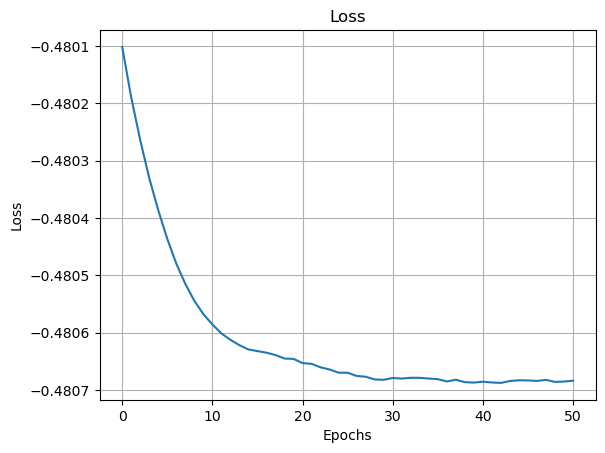

In [68]:
# Plot loss curve
epochs = range(n_epochs)

fig, ax = plt.subplots()
ax.plot(epochs, losses)

ax.set(xlabel='Epochs', ylabel='Loss',
       title='Loss')
ax.grid()
fig.savefig("loss_one.png")
plt.show()

In [69]:
# have a look at learned parameters
for name, param in model.named_parameters():
    print (name, param.data)

rnn.input_param.weight tensor([[0.]], device='cuda:0')
rnn.hidden_param.weight tensor([[1.]], device='cuda:0')
rnn.hidden_param.bias tensor([[-1.4232]], device='cuda:0')
rnn.fc1_param.weight tensor([[-1.]], device='cuda:0')
rnn.fc1_param.bias tensor([[0.4862]], device='cuda:0')
rnn.fc2_param.weight tensor([[-1.]], device='cuda:0')
out.weight tensor([[1.]], device='cuda:0')


0.20569017148090654


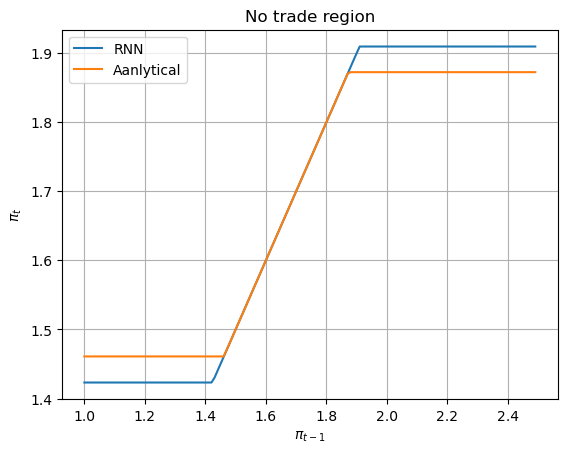

In [71]:
# Data for plotting
lowerbound = 1
upperbound = 2.5
optimal_input = Markowitz_opt
t = torch.tensor(np.arange(lowerbound, upperbound, 0.01)).to(device)
trading_cost = (2*trading_cost)/(1+trading_cost)
s = model.rnn.fc2_param.weight*F.relu(model.rnn.fc1_param.weight*F.relu(optimal_input*model.rnn.input_param.weight+model.rnn.hidden_param.weight*t-Markowitz_opt+model.rnn.hidden_param.bias)+2*model.rnn.hidden_param.bias)+Markowitz_opt+model.rnn.hidden_param.bias
delta_real = np.power(3/(4*gamma)*np.power(Markowitz_opt,2)*np.power(1-Markowitz_opt,2)*trading_cost,1/3)+((5-2*gamma)/(10*gamma)*Markowitz_opt*(Markowitz_opt)-3/(20*gamma))*trading_cost
s2 = model.rnn.fc2_param.weight*F.relu(model.rnn.fc1_param.weight*F.relu(optimal_input*model.rnn.input_param.weight+model.rnn.hidden_param.weight*t-(Markowitz_opt-delta_real))+2*delta_real)+Markowitz_opt+delta_real
s3 = model.rnn.fc2_param.weight*F.relu(model.rnn.fc1_param.weight*F.relu(optimal_input*model.rnn.input_param.weight+model.rnn.hidden_param.weight*t-(Markowitz_opt-delta))+2*delta)+Markowitz_opt+delta
print(delta_real)

fig, ax = plt.subplots()
ax.plot(t.cpu().detach(), s.cpu().view(-1).detach(), label='RNN', color = 'blue', linestyle= '--', linewidth = 1)
ax.plot(t.cpu().detach(), s2.cpu().view(-1).detach(), label='Aanlytical', color = 'red', linewidth = 1)
#ax.plot(t.cpu().detach(), s3.cpu().view(-1).detach())
ax.legend()

ax.set(xlabel=r'$\pi_{t-1}$', ylabel=r'$\pi_t$',
       title='No trade region')
ax.grid()

fig.savefig("result_one.png")
plt.show()

In [ ]:
ESR_simulated = np.log(np.power((gamma-1)*losses+1,1/(1-gamma)))/T
ESR_opt = mu*mu/sigma/sigma/2/gamma
ESR_real = mu*mu/sigma/sigma/2/gamma-gamma*sigma*sigma/2*np.power(trading_cost,2/3)*np.power(0.75/gamma*Markowitz_opt*Markowitz_opt*(1-Markowitz_opt)*(1-Markowitz_opt),2/3)
print(ESR_simulated[-1])
print(ESR_opt)
print(ESR_real)